In [1]:
import sys
sys.path.append("../")
import d2l
import torch
import torch.nn as nn
import torch.optim as optim
import time

## LeNet
![Image Name](https://cdn.kesci.com/upload/image/q5ndxi6jl5.png?imageView2/0/w/640/h/640)

In [6]:
class Flatten(torch.nn.Module):  #展平操作
    def forward(self, x):
        return x.view(x.shape[0], -1)

class Reshape(torch.nn.Module): #将图像大小重定型
    def forward(self, x):
        return x.view(-1,1,28,28)      #(B x C x H x W)

In [8]:
net = torch.nn.Sequential(     #Lelet                                                  
    Reshape(),
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), #b*1*28*28  =>b*6*28*28
    nn.Sigmoid(),                                                       
    nn.AvgPool2d(kernel_size=2, stride=2),                              #b*6*28*28  =>b*6*14*14
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),           #b*6*14*14  =>b*16*10*10
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),                              #b*16*10*10  => b*16*5*5
    Flatten(),                                                          #b*16*5*5   => b*400
    nn.Linear(in_features=16*5*5, out_features=120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [11]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size, root='../data/')
print(len(train_iter))

235


torch.Size([1, 28, 28]) 0
torch.Size([1, 28, 28]) 4
torch.Size([1, 28, 28]) 7
torch.Size([1, 28, 28]) 8
torch.Size([1, 28, 28]) 3
torch.Size([1, 28, 28]) 7
torch.Size([1, 28, 28]) 3
torch.Size([1, 28, 28]) 4
torch.Size([1, 28, 28]) 7
torch.Size([1, 28, 28]) 2


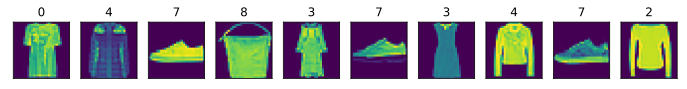

In [12]:
for Xdata,ylabel in train_iter:
    break
X, y = [], []
for i in range(10):
    print(Xdata[i].shape,ylabel[i].numpy())
    X.append(Xdata[i]) # 将第i个feature加到X中
    y.append(ylabel[i].numpy()) # 将第i个label加到y中
d2l.show_fashion_mnist(X, y)

In [15]:
# 训练
lr, num_epochs = 0.9, 10
device = d2l.try_gpu()

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)
net = net.to(device)

criterion = nn.CrossEntropyLoss()   #交叉熵描述了两个概率分布之间的距离，交叉熵越小说明两者之间越接近
d2l.train_ch5(net, train_iter, test_iter, criterion,num_epochs, batch_size,device, lr)

training on cuda:0
epoch 1, loss 0.0091, train acc 0.103, test acc 0.100, time 12.3 sec
epoch 2, loss 0.0062, train acc 0.375, test acc 0.605, time 11.3 sec
epoch 3, loss 0.0035, train acc 0.642, test acc 0.624, time 9.6 sec
epoch 4, loss 0.0029, train acc 0.713, test acc 0.711, time 10.2 sec
epoch 5, loss 0.0025, train acc 0.748, test acc 0.739, time 11.2 sec
epoch 6, loss 0.0023, train acc 0.772, test acc 0.767, time 10.5 sec
epoch 7, loss 0.0021, train acc 0.790, test acc 0.726, time 9.3 sec
epoch 8, loss 0.0020, train acc 0.805, test acc 0.786, time 9.5 sec
epoch 9, loss 0.0019, train acc 0.816, test acc 0.751, time 10.3 sec
epoch 10, loss 0.0018, train acc 0.825, test acc 0.802, time 10.2 sec


In [19]:
for testdata,testlabe in test_iter:
    testdata,testlabe = testdata.to(device),testlabe.to(device)
    break
print(testdata.shape,testlabe.shape)
net.eval()
y_pre = net(testdata)
print(torch.argmax(y_pre,dim=1)[:10])
print(testlabe[:10])

torch.Size([256, 1, 28, 28]) torch.Size([256])
tensor([9, 2, 1, 1, 2, 1, 4, 6, 5, 7], device='cuda:0')
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], device='cuda:0')


## AlxNet
![Image Name](https://cdn.kesci.com/upload/image/q5kv4gpx88.png?imageView2/0/w/640/h/640)

In [16]:
import time
import torch
from torch import nn, optim
import torchvision
import numpy as np
import sys
sys.path.append("../") 
import d2l
import os
import torch.nn.functional as F


In [18]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
         # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            #由于使用CPU镜像，精简网络，若为GPU镜像可添加该层
            #nn.Linear(4096, 4096),
            #nn.ReLU(),
            #nn.Dropout(0.5),

            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(4096, 10),
        )

    def forward(self, img):

        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [24]:
net = AlexNet()
device = d2l.try_gpu()

In [29]:
lr, num_epochs = 0.001, 3
batch_size = 16
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size,224,root='../data/')
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
d2l.train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size,device, lr)

## VGG
![Image Name](https://cdn.kesci.com/upload/image/q5l6vut7h1.png?imageView2/0/w/640/h/640)

In [ ]:
def vgg_block(num_convs, in_channels, out_channels): #卷积层个数，输入通道数，输出通道数
    blk = []
    for i in range(num_convs):
        if i == 0:
            blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        else:
            blk.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.ReLU())
    blk.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 这里会使宽高减半
    return nn.Sequential(*blk)

In [ ]:
def vgg(conv_arch, fc_features, fc_hidden_units=4096):
    net = nn.Sequential()
    # 卷积层部分
    for i, (num_convs, in_channels, out_channels) in enumerate(conv_arch):
        # 每经过一个vgg_block都会使宽高减半
        net.add_module("vgg_block_" + str(i+1), vgg_block(num_convs, in_channels, out_channels))
    # 全连接层部分
    net.add_module("fc", nn.Sequential(d2l.FlattenLayer(),
                                 nn.Linear(fc_features, fc_hidden_units),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(fc_hidden_units, fc_hidden_units),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(fc_hidden_units, 10)
                                ))
    return net

In [ ]:
ratio = 8
small_conv_arch = [(1, 1, 64//ratio), (1, 64//ratio, 128//ratio), (2, 128//ratio, 256//ratio), 
                   (2, 256//ratio, 512//ratio), (2, 512//ratio, 512//ratio)]
net = vgg(small_conv_arch, fc_features // ratio, fc_hidden_units // ratio)
print(net)

In [ ]:
batchsize=16
#batch_size = 64
# 如出现“out of memory”的报错信息，可减小batch_size或resize
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size,224,root='../data/')
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
d2l.train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size,device, lr)

##  ⽹络中的⽹络（NiN） 
LeNet、AlexNet和VGG：先以由卷积层构成的模块充分抽取 空间特征，再以由全连接层构成的模块来输出分类结果。  
NiN：串联多个由卷积层和“全连接”层构成的小⽹络来构建⼀个深层⽹络。  
⽤了输出通道数等于标签类别数的NiN块，然后使⽤全局平均池化层对每个通道中所有元素求平均并直接⽤于分类。  

![Image Name](https://cdn.kesci.com/upload/image/q5l6u1p5vy.png?imageView2/0/w/960/h/960)

1×1卷积核作用   
1.放缩通道数：通过控制卷积核的数量达到通道数的放缩。  
2.增加非线性。1×1卷积核的卷积过程相当于全连接层的计算过程，并且还加入了非线性激活函数，从而可以增加网络的非线性。  
3.计算参数少   

In [2]:
def nin_block(in_channels, out_channels, kernel_size, stride, padding):
    blk = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                        nn.ReLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size=1),
                        nn.ReLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size=1),
                        nn.ReLU())
    return blk

In [3]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, stride=4, padding=0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(96, 256, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(256, 384, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2), 
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, stride=1, padding=1),
    d2l.GlobalAvgPool2d(), 
    # 将四维的输出转成二维的输出，其形状为(批量大小, 10)
    d2l.FlattenLayer())

In [7]:
batch_size = 128
device = d2l.try_gpu()
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224, root='../data/')
criterion = nn.CrossEntropyLoss()
lr, num_epochs = 0.002, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
d2l.train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size,device, lr)

## GoogLeNet
1. 由Inception基础块组成。  
2. Inception块相当于⼀个有4条线路的⼦⽹络。它通过不同窗口形状的卷积层和最⼤池化层来并⾏抽取信息，并使⽤1×1卷积层减少通道数从而降低模型复杂度。   
3. 可以⾃定义的超参数是每个层的输出通道数，我们以此来控制模型复杂度。 

![Image Name](https://cdn.kesci.com/upload/image/q5l6uortw.png?imageView2/0/w/640/h/640)


In [9]:
class Inception(nn.Module):
    # c1 - c4为每条线路里的层的输出通道数
    def __init__(self, in_c, c1, c2, c3, c4):
        super(Inception, self).__init__()
        # 线路1，单1 x 1卷积层
        self.p1_1 = nn.Conv2d(in_c, c1, kernel_size=1)
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = nn.Conv2d(in_c, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = nn.Conv2d(in_c, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_c, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1)  # 在通道维上连结输出

In [10]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   d2l.GlobalAvgPool2d())

net = nn.Sequential(b1, b2, b3, b4, b5, 
                    d2l.FlattenLayer(), nn.Linear(1024, 10))

net = nn.Sequential(b1, b2, b3, b4, b5, d2l.FlattenLayer(), nn.Linear(1024, 10))

In [14]:
#batchsize=128
batch_size = 16
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96, root='../data/')
device = d2l.try_gpu()

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
d2l.train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size,device, lr)